<a href="https://colab.research.google.com/github/nourhan254/Autism-/blob/main/Autism_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install Dependencies and Setup

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import tensorflow as tf
import os as os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2. Remove Unwanted images

In [5]:
import cv2
import imghdr

<ipython-input-5-290956b76b78>:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [18]:
data_dir = '/content/drive/MyDrive/Autism dataset'

In [19]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [20]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Issue with image /content/drive/MyDrive/Autism dataset/AutismDataset/train
Issue with image /content/drive/MyDrive/Autism dataset/AutismDataset/valid
Issue with image /content/drive/MyDrive/Autism dataset/AutismDataset/consolidated
Issue with image /content/drive/MyDrive/Autism dataset/AutismDataset/test


In [21]:
os.listdir(data_dir)

['AutismDataset']

# 3. Load **Data**

In [22]:
import numpy as np
from matplotlib import pyplot as plt

In [25]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Autism dataset')

Found 2559 files belonging to 1 classes.


In [26]:
tf.keras.utils.image_dataset_from_directory??

In [27]:
data_iterator = data.as_numpy_iterator()

In [28]:
batch = data_iterator.next()

In [29]:
batch[0].shape

(32, 256, 256, 3)

In [30]:
#batch[1]

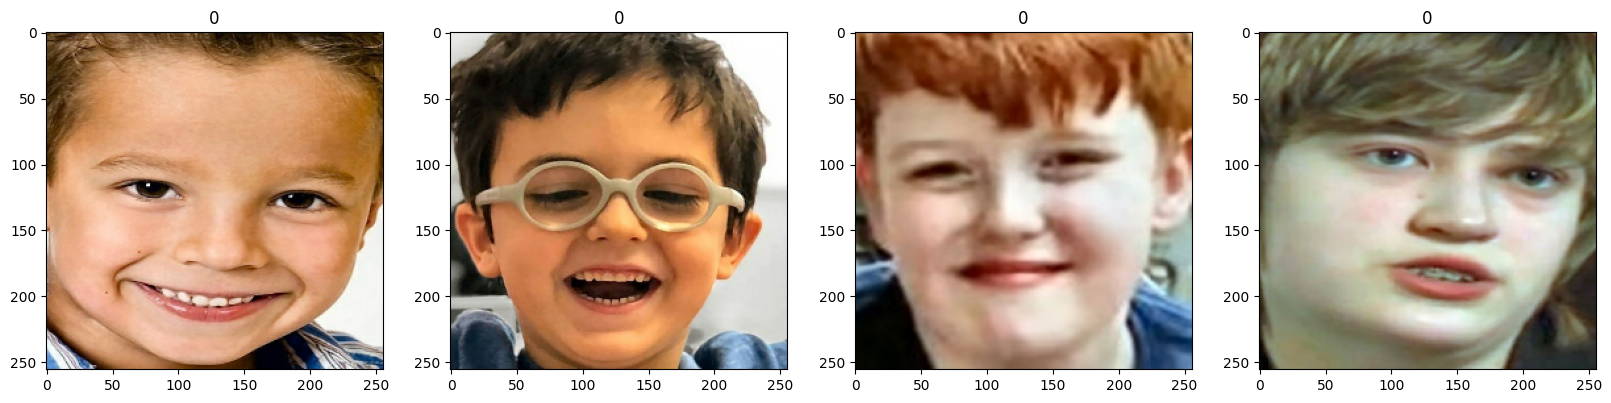

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [32]:
data = data.map(lambda x,y: (x/255, y))

In [33]:
data.as_numpy_iterator().next()

(array([[[[4.50980395e-01, 4.35294122e-01, 3.29411775e-01],
          [4.54901963e-01, 4.39215690e-01, 3.33333343e-01],
          [4.50980395e-01, 4.35294122e-01, 3.29411775e-01],
          ...,
          [4.98437136e-01, 4.16111112e-01, 3.02860498e-01],
          [5.08681178e-01, 4.30249810e-01, 3.26220989e-01],
          [5.10065079e-01, 4.31999862e-01, 3.35576773e-01]],
 
         [[4.50980395e-01, 4.35294122e-01, 3.29411775e-01],
          [4.54901963e-01, 4.39215690e-01, 3.33333343e-01],
          [4.50980395e-01, 4.35294122e-01, 3.29411775e-01],
          ...,
          [5.14917374e-01, 4.20799673e-01, 3.16334844e-01],
          [5.22709846e-01, 4.32275414e-01, 3.29926789e-01],
          [4.97206599e-01, 4.13520932e-01, 3.11636746e-01]],
 
         [[4.50980395e-01, 4.35294122e-01, 3.29411775e-01],
          [4.54901963e-01, 4.39215690e-01, 3.33333343e-01],
          [4.50980395e-01, 4.35294122e-01, 3.29411775e-01],
          ...,
          [4.96813715e-01, 3.95327806e-01, 2.9657

In [34]:
batch[0].max()

np.float32(255.0)

In [35]:
len(data)

80

5. Split Data

In [36]:
train_size = int(len(data)*.75)+1
val_size = int(len(data)*.15)
test_size = int(len(data)*.1)

In [37]:
train_size+val_size+test_size

81

In [38]:
train_size

61

In [39]:
val_size

12

In [40]:
test_size

8

In [41]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

#6. Build Deep Learning Model

In [42]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [45]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create a Sequential model
model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adding Dropout for regularization
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001)
,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Load your training and validation data using train_datagen

# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model




In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 127, 127, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,905 (14.11 MB)

 Trainable params: 3,697,265 (14.10 MB)

 Non-trainable params: 640 (2.50 KB)

7. Train

In [47]:
logdir='logs'

In [48]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [49]:
history = model.fit(
    train,
    epochs=50,
    validation_data=val,
    callbacks=[early_stop, reduce_lr])

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 318ms/step - accuracy: 0.6040 - loss: 0.8753 - val_accuracy: 1.0000 - val_loss: 0.3213 - learning_rate: 0.0010
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - accuracy: 0.8809 - loss: 0.3533 - val_accuracy: 1.0000 - val_loss: 0.1487 - learning_rate: 0.0010
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.9737 - loss: 0.1510 - val_accuracy: 1.0000 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.9949 - loss: 0.0616 - val_accuracy: 1.0000 - val_loss: 0.0259 - learning_rate: 0.0010
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - accuracy: 0.9997 - loss: 0.0322 - val_accuracy: 1.0000 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 1.0000 - loss: 0.0194 - val_accuracy: 1.0000 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.9987 - loss: 0.

8. Plot Performance

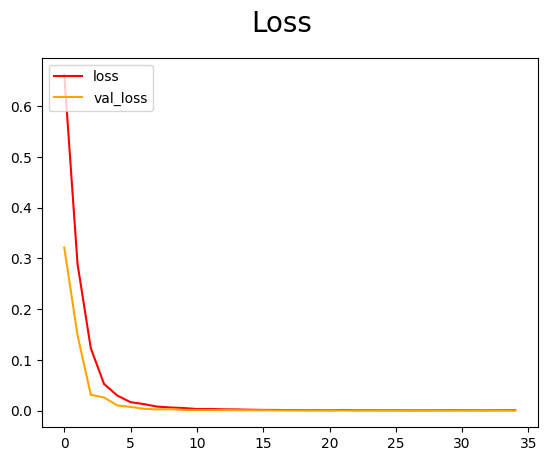

In [50]:
fig = plt.figure()
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

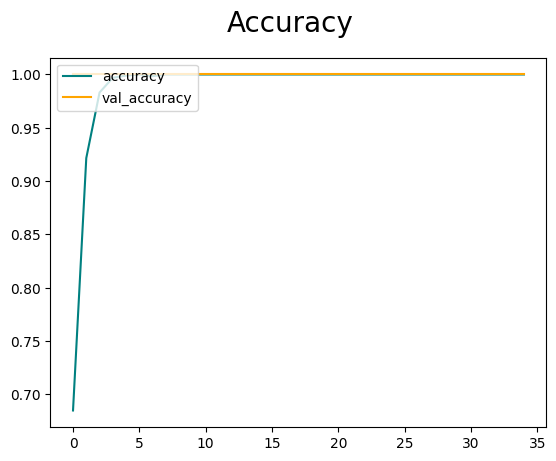

In [51]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [53]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [54]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [55]:
for batch in test.as_numpy_iterator():
    X, y = batch
    z = model.predict(X)
    pre.update_state(y, z)
    re.update_state(y, z)
    acc.update_state(y, z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [56]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


10. Test

In [57]:
import cv2 as cv2

In [74]:

!ls "/content/drive/MyDrive/Autism dataset"
!ls "/content/drive/MyDrive/Autism dataset/AutismDataset/test"



AutismDataset
Autistic.0.jpg	  Autistic.104.jpg  Autistic.109.jpg  Autistic.1.jpg
Autistic.100.jpg  Autistic.105.jpg  Autistic.10.jpg   Autistic.23.jpg
Autistic.101.jpg  Autistic.106.jpg  Autistic.110.jpg
Autistic.102.jpg  Autistic.107.jpg  Autistic.112.jpg
Autistic.103.jpg  Autistic.108.jpg  Autistic.11.jpg


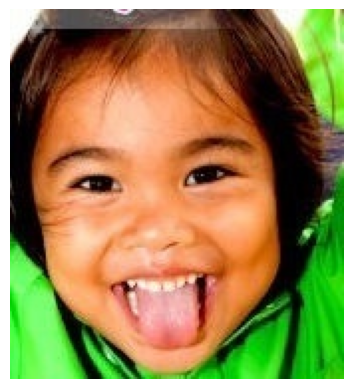

In [76]:
import cv2
import matplotlib.pyplot as plt

img_path = '/content/drive/MyDrive/Autism dataset/AutismDataset/test/Autistic.108.jpg'


img = cv2.imread(img_path)

if img is None:
    print(f"Image not found at path: {img_path}")
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


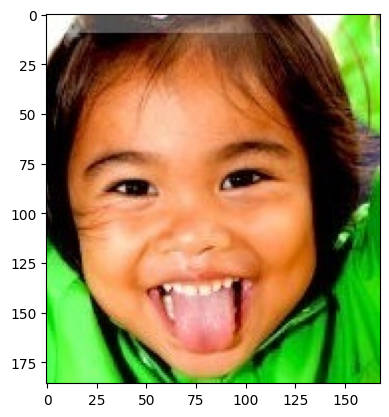

In [77]:
img = cv2.imread('/content/drive/MyDrive/Autism dataset/AutismDataset/test/Autistic.108.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

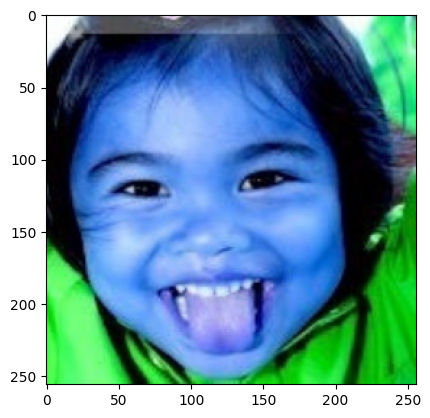

In [78]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [79]:
z= model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


In [80]:
z

array([[0.00013515]], dtype=float32)

In [81]:
if z > 0.015:
    print(f'Predicted photo is Not Autistic')
else:
    print(f'Predicted photo is Autistic')

Predicted photo is Autistic


*5.Saving the model*

In [82]:
tf.keras.models.save_model(model,'my_model2.hdf5')